In [324]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [325]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree
from tqdm import tqdm

In [326]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

In [327]:
weight_scale = 1.0
g = 1.2984752590298583 * 60

J_I = weight_scale * g
J_E = weight_scale
delay_mean_E = 10.0
delay_std_E = delay_mean_E * 0.5
delay_mean_I = 1.5
delay_std_I = delay_mean_I * 0.2
v_ext = 0.45527031369449

excitatory_type = "ss4"
inhibitory_type = "b"

In [328]:
seed = 1234

## Generate network

In [329]:
n_neurons = 500

compartment_names = ["in", "out"]

normalize_target_out_E = 15.0
normalize_target_out_I = 750.0

compartment_params = {
    "in": {"type_fractions": {"ss4": 0.8, "b": 0.2}, 
           "inhibitory_types": ("b",), 
           "p0_by_pair": {"EE": 0.5, "EI": 0.5, "IE": 0.5, "II": 0.5},
           "mu_E": 1.0, "sigma_E": 1.6, "mu_I": 30.0, "sigma_I": 6.0,
           "lambda_by_preclass": {"E": 0.2, "I": 0.05},
           "weight_dist_by_ntype": {"ss4": "lognormal", "b": "normal"},
           "outdegree_config_by_type": {
                "ss4": {"dist": "lognormal", "params": (2.65, 0.8)},
                "b":   {"dist": "neg-bin", "params": (50, 40)},
            },
           "normalize_mode": "out",
           "normalize_target_out_E": normalize_target_out_E,
           "normalize_target_out_I": normalize_target_out_I,
           "weight_clip": (1e-4, 100.0),
           "distance_scale": 20.0,
    },
    
    
    "out": {"type_fractions": {"ss4": 0.8, "b": 0.2}, 
           "inhibitory_types": ("b",), 
           "p0_by_pair": {"EE": 0.5, "EI": 0.5, "IE": 0.5, "II": 0.5}, 
           "mu_E": 1.0, "sigma_E": 1.6, "mu_I": 30.0, "sigma_I": 6.0,
           "lambda_by_preclass": {"E": 0.2, "I": 0.05},
           "weight_dist_by_ntype": {"ss4": "lognormal", "b": "normal"},
           "outdegree_config_by_type": {
                "ss4": {"dist": "lognormal", "params": (2.65, 0.8)},
                "b":   {"dist": "neg-bin", "params": (50, 40)},
            },
           "normalize_mode": "out",
           "normalize_target_out_E": normalize_target_out_E,
           "normalize_target_out_I": normalize_target_out_I,
           "weight_clip": (1e-4, 100.0),
           "distance_scale": 20.0,
    },
}

inter_distance_scale = 1.0
compartment_distribution = {"in": 0.5, "out": 0.5}

inter_compartment_matrix=[[0, 0.01],
                          [0.005, 0]]

inter_weight_pair_scale = {"EE": 25.0, "EI": 25.0, "IE": 25.0, "II": 25.0}

# compartment_distance_matrix=[[0.0, inter_distance_scale],
#                              [inter_distance_scale, 0.0]]

compartment_centers = {
    "in": (0.0, 0.0),
    "out": (20.0, 0.0),
}

inter_distance_jitter=0.15



G = generate_multi_compartment_spatial_ei_network(
    n_total_neurons=n_neurons,
    compartment_names=compartment_names,
    compartment_params=compartment_params,
    compartment_distribution=compartment_distribution,
    inter_distance_scale=inter_distance_scale,
    inter_compartment_matrix=inter_compartment_matrix,
    inter_weight_pair_scale=inter_weight_pair_scale,
    compartment_centers=compartment_centers,
    inter_distance_jitter=inter_distance_jitter,
    # compartment_distance_matrix=compartment_distance_matrix,

)

In [330]:
# Half all distances of edges going out of inhibitory neurons
for u, v in G.edges():
    if G.nodes[u]['inhibitory']:
        G[u][v]['distance'] *= 0.25

## Analysis

Text(0.5, 1.0, 'b Weight Distribution after Lognormal Redistribution')

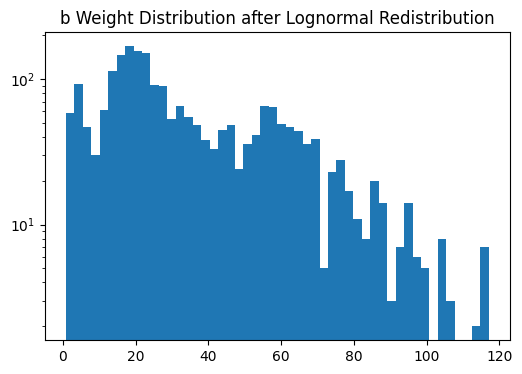

In [331]:
# Plot ss4 weight distribution
n_test_type = "b"
weights = [G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['ntype'] == n_test_type]
plt.figure(figsize=(6,4))
plt.hist(weights, bins=50, log=True)
plt.title(f"{n_test_type} Weight Distribution after Lognormal Redistribution")

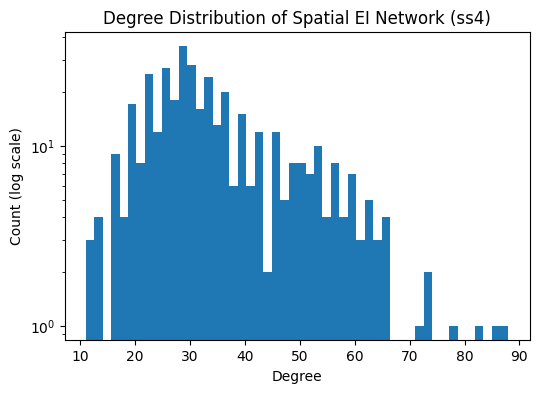

In [332]:
# Plot degree distribution
n_type_show = "ss4"
degrees = [G.degree(n) for n in G.nodes() if G.nodes[n]['ntype'] == n_type_show]
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=50, log=True)
plt.title(f"Degree Distribution of Spatial EI Network ({n_type_show})")
plt.xlabel("Degree")
plt.ylabel("Count (log scale)")
plt.show()

In [333]:
enable_plot = False

if enable_plot:
    # Plot graph G using "pos" attribute for node positions
    pos = nx.get_node_attributes(G, 'pos')
    # Edge thinckness proportional to weight
    edges = G.edges()
    weights = [G[u][v]['weight'] / 200.0 for u, v in edges]
    # Node size proportional to degree
    degrees = [G.degree(n) for n in G.nodes()]
    # Node color by neuron type
    ntypes = nx.get_node_attributes(G, 'ntype')
    # Map neuron types to colors
    color_map = {'ss4': 'blue', 'b': 'red'}
    node_colors = [color_map.get(ntypes[n], 'gray') for n in G.nodes()]
    # Edge alpha
    alphas = [0.2 + 0.8 * G[u][v]['weight'] / 10.0 for u, v in edges]
    plt.figure(figsize=(8,8))
    nx.draw(G, pos, node_size=degrees, width=weights, edge_cmap=plt.cm.viridis, node_color=node_colors, alpha=0.65, with_labels=False)
    plt.title("Spatial EI Network Visualization")
    plt.show()

Total inter-compartment weight: 5478.36
Total intra-compartment weight: 81000.00


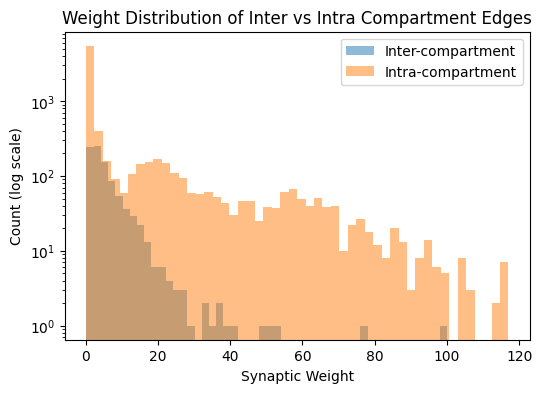

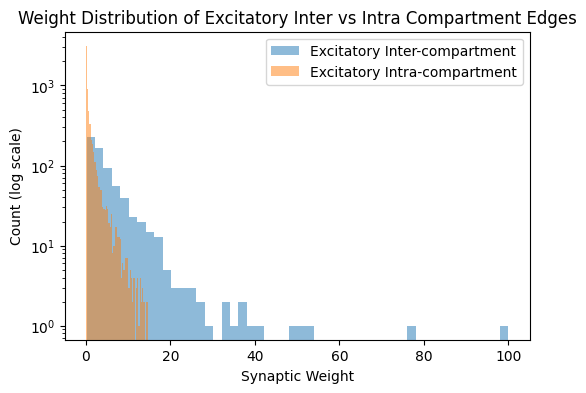

In [334]:
# Weight distribution of edges between compartments
inter_compartment_edges = {(u, v): G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] != G.nodes[v]['compartment']}
intra_compartment_edges = {(u, v): G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] == G.nodes[v]['compartment']}

# Total sum
total_inter_weight = sum(inter_compartment_edges.values())
total_intra_weight = sum(intra_compartment_edges.values())
print(f"Total inter-compartment weight: {total_inter_weight:.2f}")
print(f"Total intra-compartment weight: {total_intra_weight:.2f}")

# Plot distribution of inter vs intra compartment weights
plt.figure(figsize=(6,4))
plt.hist(list(inter_compartment_edges.values()), bins=50, alpha=0.5, label='Inter-compartment', log=True)
plt.hist(list(intra_compartment_edges.values()), bins=50, alpha=0.5, label='Intra-compartment', log=True)
plt.title("Weight Distribution of Inter vs Intra Compartment Edges")
plt.xlabel("Synaptic Weight")
plt.ylabel("Count (log scale)")
plt.legend()
plt.show()

# Plot where the presynaptic neurons are only exctiatory
exc_inter_compartment_edges = {(u, v): G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] != G.nodes[v]['compartment'] and G.nodes[u]['ntype'] == 'ss4'}
exc_intra_compartment_edges = {(u, v): G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] == G.nodes[v]['compartment'] and G.nodes[u]['ntype'] == 'ss4'}
plt.figure(figsize=(6,4))
plt.hist(list(exc_inter_compartment_edges.values()), bins=50, alpha=0.5, label='Excitatory Inter-compartment', log=True)
plt.hist(list(exc_intra_compartment_edges.values()), bins=50, alpha=0.5, label='Excitatory Intra-compartment', log=True)
plt.title("Weight Distribution of Excitatory Inter vs Intra Compartment Edges")
plt.xlabel("Synaptic Weight")
plt.ylabel("Count (log scale)")
plt.legend()
plt.show()

In [335]:
# Total sum of weights going from "in" compartment to "out" compartment
total_weight_in_to_out = sum(G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] == 'in' and G.nodes[v]['compartment'] == 'out')
print(f"Total weight from 'in' to 'out': {total_weight_in_to_out:.2f}")

# Total sum of weights going from "out" compartment to "in" compartment
total_weight_out_to_in = sum(G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] == 'out' and G.nodes[v]['compartment'] == 'in')
print(f"Total weight from 'out' to 'in': {total_weight_out_to_in:.2f}")

Total weight from 'in' to 'out': 3543.61
Total weight from 'out' to 'in': 1934.75


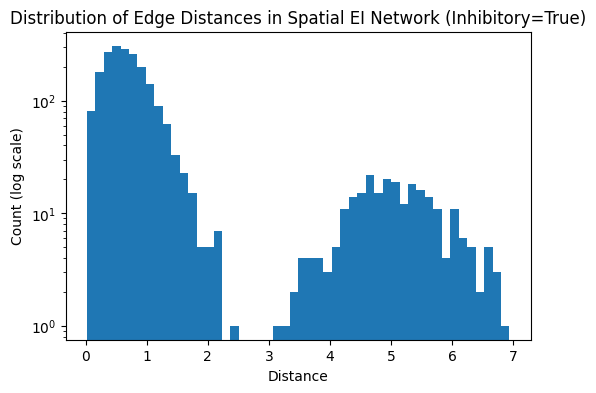

In [336]:
# Print distribution of "distance" attribute for edges
if_inhibitory = True
distances = [G[u][v]['distance'] for u, v in G.edges() if G.nodes[u]['inhibitory'] == if_inhibitory]
plt.figure(figsize=(6,4))
plt.hist(distances, bins=50, log=True)
plt.title(f"Distribution of Edge Distances in Spatial EI Network (Inhibitory={if_inhibitory})")
plt.xlabel("Distance")
plt.ylabel("Count (log scale)")
plt.show()

## Simulation setup

In [337]:
dt = 0.1

In [338]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 1000)
threshold_mult = 1.05

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay, threshold_mult=threshold_mult)

In [339]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

In [340]:
nmda_weight = np.ones(connectome.neuron_population.n_neurons, dtype=float)
nmda_weight[pop.inhibitory_mask.astype(bool)] = 0.959685703507305 * 0.5
# Invert to make excitatory neurons have NMDA weight 1, inhibitory 0
# nmda_weight

In [341]:
connectome.compute_metrics(small_world=False)

{'spectral_radius': 191.85699581507842,
 'n_nodes': 500,
 'n_edges': 9087,
 'n_E': 400,
 'n_I': 100,
 'k_in_mean': 18.174,
 'k_out_mean': 18.174,
 's_in_mean': 172.95672152229062,
 's_out_mean': 172.95672152229062,
 'k_in_std': 5.646191899495789,
 'k_out_std': 11.5220327406649,
 's_in_std': 85.73647765505783,
 's_out_std': 296.74412455973385,
 'edge_frac_EE': 0.6047100253108837,
 'edge_frac_EI': 0.1513150654781556,
 'edge_frac_IE': 0.19852536590734016,
 'edge_frac_II': 0.045449543303620554,
 'reciprocity': 0.17145372510179377,
 'assort_out_to_in_degree': 0.04684225475864522,
 'assort_outStrength_to_inStrength': 0.15673497412922066,
 'clustering_avg_weighted': 0.010176407856946354,
 'transitivity_unweighted': 0.1872737311587279,
 'rich_club_phi_k': 0.19978858350951373,
 'rich_club_k_sel': 50,
 'triadic_census': {'003': 16854696,
  '012': 3250078,
  '102': 339027,
  '021D': 67331,
  '021U': 48905,
  '021C': 90278,
  '111D': 15910,
  '111U': 21832,
  '030T': 10316,
  '030C': 1930,
  '201'

## Find output neurons

In [342]:
# Choose top 20 % of neurons by out-degree in compartment "out"
out_degrees = dict(G.out_degree())
top_neurons_out = sorted(out_degrees, key=out_degrees.get, reverse=True)
compartment_out_neurons = [n for n in top_neurons_out if G.nodes[n]['compartment'] == 'out' and G.nodes[n]['ntype'] == 'ss4']
top_neurons_out = compartment_out_neurons[:int(0.2 * len(compartment_out_neurons))]
# Shuffle top neurons to avoid any ordering effects
random.shuffle(top_neurons_out)
length_top_neurons_out = len(top_neurons_out)
print(f"Top 20% of excitatory neurons by out-degree in 'out' compartment: {length_top_neurons_out} neurons")
# Check neuron types of top neurons
top_neuron_types = [G.nodes[n]['ntype'] for n in top_neurons_out]
type_counts = Counter(top_neuron_types)
print("Neuron type distribution among top neurons:")
for ntype, count in type_counts.items():
    print(f"  {ntype}: {count} neurons")

Top 20% of excitatory neurons by out-degree in 'out' compartment: 40 neurons
Neuron type distribution among top neurons:
  ss4: 40 neurons


## Find input neurons

In [343]:
# Choose top 20 % of neurons by out-degree in compartment "in"
out_degrees = dict(G.out_degree())
top_neurons_in = sorted(out_degrees, key=out_degrees.get, reverse=True)
compartment_out_neurons = [n for n in top_neurons_in if G.nodes[n]['compartment'] == 'in' and G.nodes[n]['ntype'] == 'ss4']
top_neurons_in = compartment_out_neurons[:int(0.2 * len(compartment_out_neurons))]
# Shuffle top neurons to avoid any ordering effects
random.shuffle(top_neurons_in)
length_top_neurons_in = len(top_neurons_in)
print(f"Top 20% of excitatory neurons by out-degree in 'in' compartment: {length_top_neurons_in} neurons")
# Check neuron types of top neurons
top_neuron_types = [G.nodes[n]['ntype'] for n in top_neurons_in]
type_counts = Counter(top_neuron_types)
print("Neuron type distribution among top neurons:")
for ntype, count in type_counts.items():
    print(f"  {ntype}: {count} neurons")

Top 20% of excitatory neurons by out-degree in 'in' compartment: 40 neurons
Neuron type distribution among top neurons:
  ss4: 40 neurons


In [344]:
input_neurons_1 = top_neurons_in[int(0.5 * len(top_neurons_in)):]
input_neurons_2 = top_neurons_in[:int(0.5 * len(top_neurons_in))]

input_1_mask = np.zeros(n_neurons, dtype=bool)
input_2_mask = np.zeros(n_neurons, dtype=bool)

input_1_mask[input_neurons_1] = True
input_2_mask[input_neurons_2] = True

## Find plastic neurons

In [345]:
# Choose top 10 % of neurons by out-degree in compartment "in"
out_degrees = dict(G.out_degree())
top_neurons_plastic = sorted(out_degrees, key=out_degrees.get, reverse=True)
compartment_out_neurons = [n for n in top_neurons_plastic if G.nodes[n]['ntype'] == 'ss4']
top_neurons_plastic = compartment_out_neurons[:int(0.1 * len(compartment_out_neurons))]
# Shuffle top neurons to avoid any ordering effects
random.shuffle(top_neurons_plastic)
length_top_neurons_plastic = len(top_neurons_plastic)
print(f"Top 20% of excitatory neurons by out-degree for plasticity: {length_top_neurons_plastic} neurons")
# Check compartment distribution of top neurons
compartment_counts = Counter(G.nodes[n]['compartment'] for n in top_neurons_plastic)
print("Compartment distribution among top neurons:")
for compartment, count in compartment_counts.items():
    print(f"  {compartment}: {count} neurons")

plastic_mask = np.isin(np.arange(n_neurons), top_neurons_plastic)

Top 20% of excitatory neurons by out-degree for plasticity: 40 neurons
Compartment distribution among top neurons:
  in: 18 neurons
  out: 22 neurons


## Simulation

In [346]:
dt = 0.1

In [347]:
def sim_w_input(sim, sim_len_ms, input_mask, input_rate, input_amp):
    poisson = PoissonInput(n_neurons, rate=input_rate * input_mask, amplitude=input_amp)
    steps = int(sim_len_ms / dt)
    for _ in tqdm(range(steps)):
        sim.step(spike_ext=poisson(dt))

In [348]:
# sim.connectome.W[plastic_mask, :] *= 0.5

100%|██████████| 5000/5000 [00:00<00:00, 5090.90it/s]


Reward signal:  3.9000000000000554
Max weight change: 1.0131851508049436
Min weight change: -17.496750752741786


100%|██████████| 5000/5000 [00:01<00:00, 4925.08it/s]


Reward signal:  -4.500000000000018
Max weight change: 46.73378919327862
Min weight change: -25.79717009793977


100%|██████████| 5000/5000 [00:01<00:00, 4931.86it/s]


Reward signal:  2.2000000000000153
Max weight change: 4.280578660913392
Min weight change: -12.464114539325323


100%|██████████| 5000/5000 [00:01<00:00, 4887.99it/s]


Reward signal:  -0.09999999999999964
Max weight change: 1.059181136079129
Min weight change: -0.29732588678598226


100%|██████████| 5000/5000 [00:01<00:00, 4521.28it/s]


Reward signal:  1.7999999999999883
Max weight change: 0.5346810794435441
Min weight change: -4.581665452568197


100%|██████████| 5000/5000 [00:01<00:00, 4500.42it/s]


Reward signal:  -0.9999999999999929
Max weight change: 5.591440689749973
Min weight change: -1.3149172309795087


100%|██████████| 5000/5000 [00:01<00:00, 4414.86it/s]


Reward signal:  0.09999999999999787
Max weight change: 0.4514834191650059
Min weight change: -0.9905307367443825


100%|██████████| 5000/5000 [00:01<00:00, 4417.28it/s]


Reward signal:  0.5999999999999996
Max weight change: 0.010903005403537794
Min weight change: -3.6745891347527504


100%|██████████| 5000/5000 [00:01<00:00, 4398.24it/s]


Reward signal:  -1.1999999999999922
Max weight change: 10.898408666253019
Min weight change: -3.9054227247833957


100%|██████████| 5000/5000 [00:01<00:00, 4407.79it/s]


Reward signal:  0.8999999999999861
Max weight change: 0.35107983858323877
Min weight change: -5.130430832505141


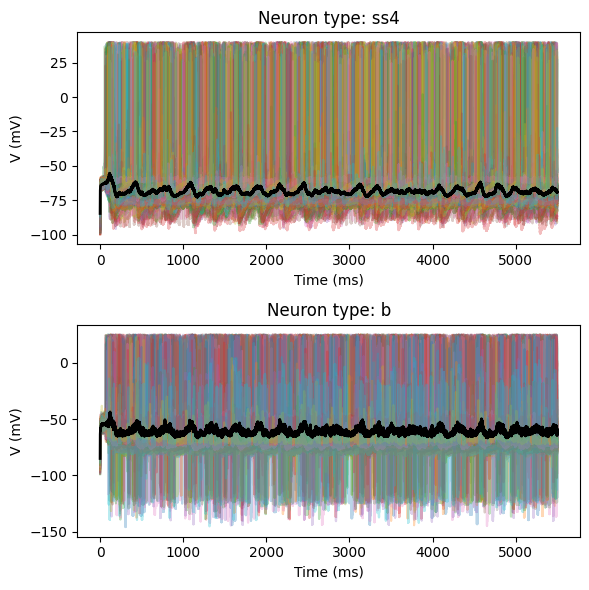

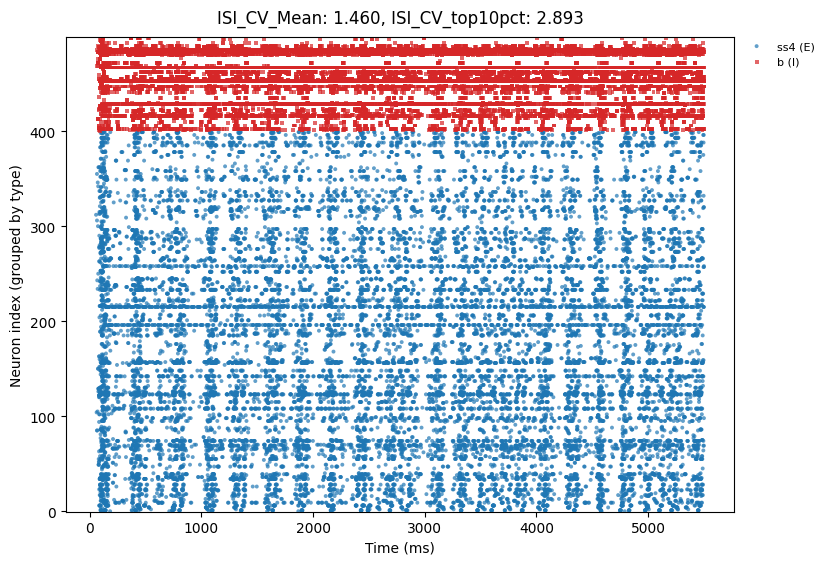

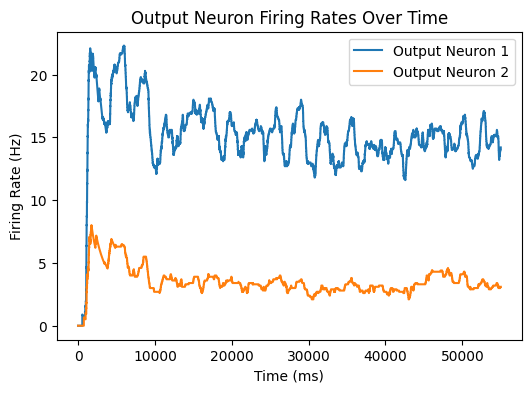

In [352]:

# Randomize initial voltages
Vs = rng.uniform(-100, -70, size=n_neurons)
us = rng.uniform(0, 400, size=n_neurons)
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes, dtype=float)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

# sim = Simulation(connectome, dt, stepper_type="simple", state0=state0,
#                  enable_plasticity=False)
sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0,
                synapse_kwargs={"LT_scale": 1.0, "NMDA_weight": nmda_weight}, synapse_type="standard",
                 enable_debug_logger=True,
                 enable_plasticity=True, plasticity="stdp_masked", plasticity_step="sparse_pre_post",
                 plasticity_kwargs={"plastic_source_mask": plastic_mask, "weight_multiplicity": "weight_stab", 
                                    "max_weight": 100.0, "weight_update_scale": 30.0})

sim.configure_output_readout(output_neuron_indices=top_neurons_out, output_dim=2, rate_window_ms=500.0,
                             enable_logger=True)

# rate = np.zeros(n_neurons)
amplitude = 2.44625509556019 * 0.25

# To kickstart SSAI
sim_w_input(sim, sim_len_ms=500.0, input_mask=~pop.inhibitory_mask.astype(bool), input_rate=v_ext, input_amp=amplitude)

output = sim.read_output_vector()
output_delta_prev = output[1] - output[0]

amplitude = 2.44625509556019 * 1.0

rounds = 10

for r in range(rounds):
    sim_w_input(sim, sim_len_ms=500.0, input_mask=input_1_mask, input_rate=v_ext, input_amp=amplitude)

    output = sim.read_output_vector()
    output_delta = output[1] - output[0]
    if output_delta < 0:
        reward = (output_delta - output_delta_prev)
    elif output_delta_prev < 0 and output_delta_prev > 0:
        reward = output_delta
    else:
        reward = 0.0

    output_delta_prev = output_delta

    W_old = sim.connectome.W.copy()

    print("Reward signal: ", reward)

    sim.apply_reward(reward)

    W_new = sim.connectome.W.copy()

    max_change = np.max(W_new - W_old)
    print(f"Max weight change: {max_change}")
    min_change = np.min(W_new - W_old)
    print(f"Min weight change: {min_change}")


sim.plot_voltage_per_type(figsize=(6, 6))

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}", t_start_ms=0.0, t_stop_ms=9000.0)

# Plot output
output_history = np.array(sim.output_logger)
plt.figure(figsize=(6,4))
plt.plot(output_history[:, 0], label="Output Neuron 1")
plt.plot(output_history[:, 1], label="Output Neuron 2")
plt.title("Output Neuron Firing Rates Over Time")
plt.xlabel("Time (ms)")
plt.ylabel("Firing Rate (Hz)")
plt.legend()
plt.show()

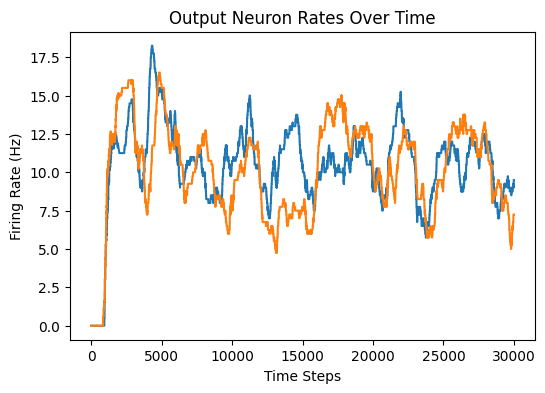

In [943]:
output_rates = np.array(output_rates)
plt.figure(figsize=(6,4))
plt.plot(output_rates)
plt.title("Output Neuron Rates Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Firing Rate (Hz)")
plt.show()

In [944]:
sim.stats.compute_metrics(dt, bin_ms_participation=300, t_start_ms=500.0, t_stop_ms=2500.0)

{'rate_mean_Hz': 12.482375881205938,
 'rate_median_Hz': 5.499725013749312,
 'rate_p95_Hz': 50.19749012549354,
 'rate_mean_Hz_E': 8.920803959802008,
 'rate_mean_Hz_I': 26.72866356682166,
 'rate_mean_Hz_E_active2spk': 11.249437528123593,
 'rate_mean_Hz_I_active2spk': 39.863678457868154,
 'ISI_CV_median': 1.7296125497588626,
 'ISI_CV_mean': 1.871943516747764,
 'ISI_CV_mean_E': 1.7062582381599292,
 'ISI_CV_mean_I': 2.6213507768219726,
 'ISI_CV_mean_top10pct': 3.648401559845916,
 'refractory_violations_per_neuron': 0.86,
 'Fano_median_2ms': 0.9934934934934863,
 'Fano_median_10ms': 1.6300307240301328,
 'Fano_median_50ms': 2.1552706552706544,
 'Fano_median_100ms': 2.3033312268664803,
 'Fano_median_300ms': 2.0000000000000004,
 'Fano_median_500ms': 2.0,
 'Fano_median_1000ms': 1.380952380952381,
 'mean_noise_corr_2ms': 0.013902604456038558,
 'mean_noise_corr_10ms': 0.038629663006638504,
 'mean_noise_corr_50ms': 0.11806032631679514,
 'mean_noise_corr_100ms': 0.1828368015324487,
 'mean_noise_corr_

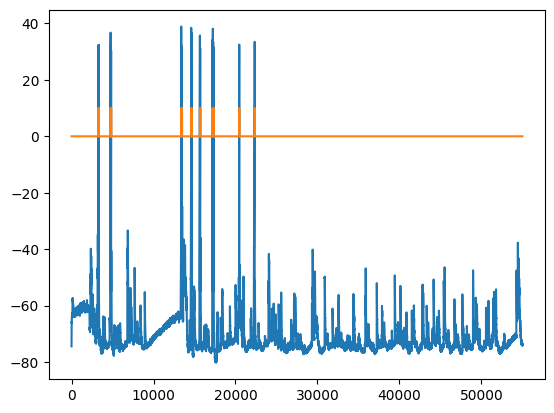

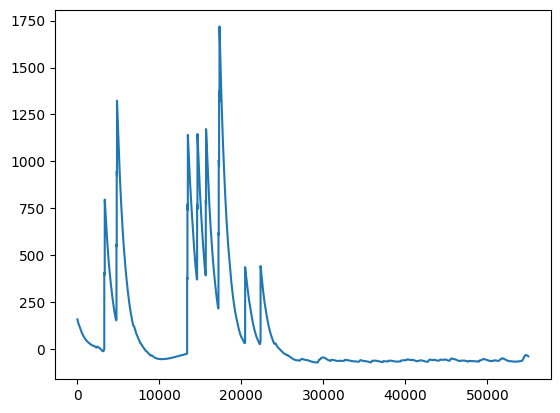

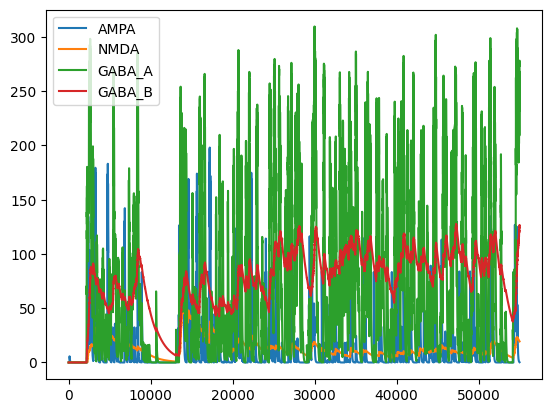

In [945]:
# Plot spikes for one neuron
n_idx = 101
t_first = 0
t_last = -1
plt.plot(np.array(sim.stats.Vs)[t_first:t_last,n_idx])
plt.plot(np.array(sim.stats.spikes)[t_first:t_last,n_idx] * 10)
plt.show()
plt.plot(np.array(sim.stats.us)[t_first:t_last,n_idx])
plt.show()
plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
plt.legend()
plt.show()

In [946]:
# plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
# plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
# plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
# plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
# plt.legend()
# plt.show()

In [947]:
# connectome.compute_metrics(small_world=False)